## Setting Up

### Import packages here

In [1]:
import pickle
import numpy as np
import xarray as xr
from pandas import to_datetime, read_csv, Timedelta, Timestamp
from netCDF4 import Dataset
from wrf import getvar, ll_to_xy
import glob as gl
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colorbar, colors
import cmocean
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.spatial import KDTree
from datetime import datetime

In [2]:
# some parameters
plt.rcParams.update({'font.size': 14})
dpi = 200
K2C = -273.15

### Set the directories and get list of filenames

In [3]:
# year of anaylsis
year = 2018
months = [6,7,8]

training_set = False
test_set = False

if training_set:
    run_numbers = range(1,19)
    nens = 18
    full_name_prefix = '9_variable_korobov_'
    output_filename = '../output/wfv_buoy_temperature_training_set.pkl'
elif test_set:
    run_numbers = [1,3,5,6,9]
    nens = 19
    full_name_prefix = '8_variable_korobov_'
    output_filename = '../output/wfv_buoy_temperature_test_set.pkl'
else:
    run_numbers = ['run_BO1'] #Bayesian Optimization run
    nens = 1
    full_name_prefix = '9_variable_'
    output_filename = '../output/wfv_buoy_temperature_BO1.pkl'

runs_full_name = []
for run in run_numbers:
    runs_full_name.append(full_name_prefix + str(run))

# directories
proj_dir = '/lus/grand/projects/COMPASS-GLM/'
home_dir = proj_dir + 'GLM_Evaluation/'
buoy_dir = home_dir + 'NDBC/'
wrf_meta_dir = home_dir + 'WRF_metadata/'

# filenames

# buoy data
buoy_file = '../output/buoy_2018_JJA_processed.pkl'

# wrf + fvcom coupled
proj_dir = '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/'

# wrf + fvcom coupled
fv_lists = []
wrf_lists = []
for rdx,run in enumerate(run_numbers):
    if nens == 19:
        wfv_dir = proj_dir + 'korobov_run' + str(run) + '/'
    elif nens == 18:
        wfv_dir = proj_dir + 'run' + str(run).rjust(2,'0') + '/'
    elif nens == 1:
        wfv_dir = proj_dir + run + '/'
    fv_list = gl.glob(wfv_dir + 'output_fvcom*/gl_0*.nc')
    fv_list.sort()
    fv_lists.append(fv_list)
    
    wrf_list = gl.glob(wfv_dir + 'output_wrf/cstm_d01*')
    wrf_list.sort()
    wrf_lists.append(wrf_list)
    if rdx == 0:
        print(output_filename)
        print(fv_list[0:10])
        print(wrf_list[0:10])

../output/wfv_buoy_temperature_BO1.pkl
['/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run_BO1/output_fvcom0/gl_0001.nc', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run_BO1/output_fvcom0/gl_0002.nc', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run_BO1/output_fvcom0/gl_0003.nc', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run_BO1/output_fvcom0/gl_0004.nc', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run_BO1/output_fvcom0/gl_0005.nc', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run_BO1/output_fvcom0/gl_0006.nc', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run_BO1/output_fvcom0/gl_0007.nc', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run_BO1/output_fvcom0/gl_0008.nc', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run_BO1/output_fvcom0/gl_0009.nc

### Read NBDC buoy data

In [4]:
with open(buoy_file, 'rb') as fp:
    buoy_data = pickle.load(fp)
    print('Done read bouy_data')

Done read bouy_data


In [5]:
# make buoy lon and lat vectors
buoy_names = [bd['name'] for bd in buoy_data]
buoy_lon = [bd['lon'] for bd in buoy_data]
buoy_lon2 = [bd['lon']+360 for bd in buoy_data]
buoy_lat = [bd['lat'] for bd in buoy_data]

## Processing

In [6]:
wfv_runs = {'runs': runs_full_name,
            'LST': [],
            'T2': []}

### Get time series of WRF+FVCOM lake surface temperature at the buoy_locations

In [7]:
# WRF+FVCOM lake surface temperature
wfv_runs['LST'] = []
for fv_list in fv_lists:
    wfv_LakeT_at_buoys = np.empty((len(fv_list)*24,len(buoy_data)))
    wfv_time = np.empty(len(fv_list)*24,dtype='datetime64[s]')
    nn = 0
    for idx, fvcom_fname in enumerate(fv_list):
        #print(fvcom_fname)
        wfv_temp = xr.open_dataset(fvcom_fname,decode_times=False,drop_variables=['siglay','siglev'])
        ddhh_vec = [to_datetime('1858-11-17') + Timedelta(int(time_val*24),'h') 
                for time_val in wfv_temp.time.values]
        if idx == 0:
            wfv_grid_tree = KDTree(np.c_[wfv_temp.lon.values, wfv_temp.lat.values])
            wfv_d, wfv_grid_ind = wfv_grid_tree.query(np.c_[buoy_lon2,buoy_lat])
        lst_temp = wfv_temp['temp'].isel(siglay=0,node=wfv_grid_ind).values
        for ii,ddhh in enumerate(ddhh_vec):
            wfv_time[nn] = np.datetime64(ddhh)
            wfv_LakeT_at_buoys[nn,:] = lst_temp[ii,:]
            nn += 1
    # remove non-unique values
    wfv_time, idx_start = np.unique(wfv_time[0:nn], return_index=True)
    wfv_LakeT_at_buoys = wfv_LakeT_at_buoys[idx_start,:]
   
    wfv_runs['LST'].append([wfv_time,wfv_LakeT_at_buoys])
    
    # save as we go
    with open(output_filename, 'wb') as fp:
        pickle.dump(wfv_runs, fp)
        print('Done writing list into a binary file')

Done writing list into a binary file


In [8]:
# WRF+FVCOM lake T2 air temperature
wfv_runs['T2'] = []
for wrf_list in wrf_lists:
    wfv_LakeT_at_buoys = np.empty((len(wrf_list),len(buoy_data)))
    wfv_time = np.empty(len(wrf_list),dtype='datetime64[s]')
    for idx, wrf_fname in enumerate(wrf_list):
        wfv_temp = xr.open_dataset(wrf_fname)
        ddhh = datetime.fromisoformat(wrf_fname[-19::])
        if idx == 0:
            wfv_grid_tree = KDTree(np.c_[wfv_temp['XLONG'].values.flatten(), 
                                         wfv_temp['XLAT'].values.flatten()])
            wfv_d, wfv_grid_ind = wfv_grid_tree.query(np.c_[buoy_lon,buoy_lat])
        wfv_LakeT_at_buoys[idx,:] = wfv_temp['T2'].values.flatten()[wfv_grid_ind] + K2C
        wfv_time[idx] = np.datetime64(ddhh)
            
    wfv_runs['T2'].append([wfv_time,wfv_LakeT_at_buoys])
    
    # save as we go
    with open(output_filename, 'wb') as fp:
        pickle.dump(wfv_runs, fp)
        print('Written data into the output binary file')

Written data into the output binary file


## Plotting

In [9]:
buoy_av_LST = [bd['data']['LST'].mean() for bd in buoy_data]
buoy_av_T2 = [bd['data']['T2'].mean() for bd in buoy_data]

### Plot buoy locations and mean temps

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


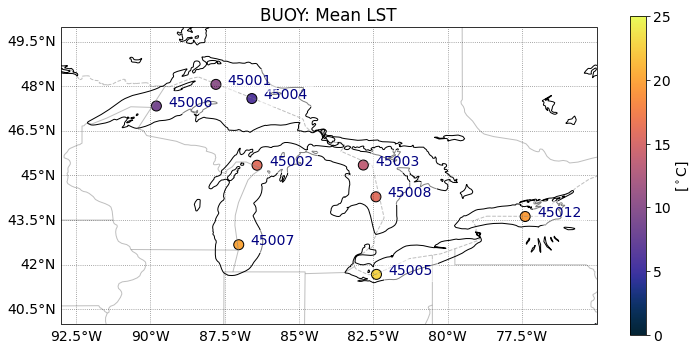

In [10]:
# Create a figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent([-93, -75, 40,50])

# Download and add the states and coastlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(cfeature.BORDERS, edgecolor='gray',linestyle="dashed", alpha=0.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        facecolor='none',        
        scale='50m')
ax.add_feature(lakes)

vmin = 0
vmax = 25

plt.scatter(buoy_lon,buoy_lat,s=100,
            c=buoy_av_LST,cmap=cmocean.cm.thermal,vmin=vmin,vmax=vmax,edgecolor='black') 
for idx,buoy_name in enumerate(buoy_names):
    if np.isnan(buoy_av_LST[idx]):
        plt.plot(buoy_lon[idx],buoy_lat[idx],'rx')
    plt.annotate(buoy_name,(buoy_lon[idx]+0.4,buoy_lat[idx]),
                 color='navy',backgroundcolor=(1,1,1,0.5))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98, label='[$^\circ$C]')

# Add the gridlines
gll = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
gll.xlabels_top = None
gll.ylabels_right = None
gll.xformatter = LONGITUDE_FORMATTER
gll.yformatter = LATITUDE_FORMATTER

plt.title("BUOY: Mean LST")

plt.show()
#fig.savefig('buoy_mean_LST.png',format='png',dpi=dpi,bbox_inches='tight')

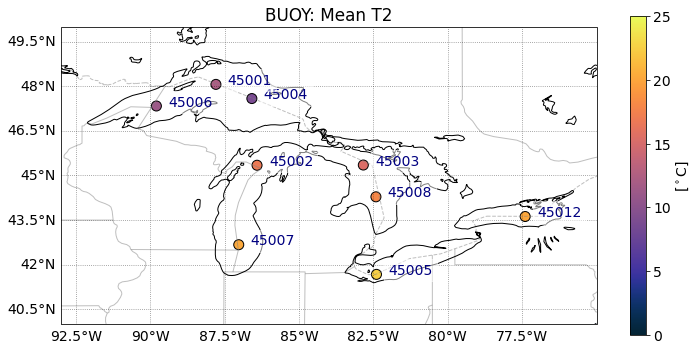

In [11]:
# Create a figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent([-93, -75, 40,50])

# Download and add the states and coastlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(cfeature.BORDERS, edgecolor='gray',linestyle="dashed", alpha=0.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        facecolor='none',        
        scale='50m')
ax.add_feature(lakes)

vmin = 0
vmax = 25

plt.scatter(buoy_lon,buoy_lat,s=100,
            c=buoy_av_T2,cmap=cmocean.cm.thermal,vmin=vmin,vmax=vmax,edgecolor='black') 
for idx,buoy_name in enumerate(buoy_names):
    if np.isnan(buoy_av_LST[idx]):
        plt.plot(buoy_lon[idx],buoy_lat[idx],'rx')
    plt.annotate(buoy_name,(buoy_lon[idx]+0.4,buoy_lat[idx]),
                 color='navy',backgroundcolor=(1,1,1,0.5))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98, label='[$^\circ$C]')

# Add the gridlines
gll = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
gll.xlabels_top = None
gll.ylabels_right = None
gll.xformatter = LONGITUDE_FORMATTER
gll.yformatter = LATITUDE_FORMATTER

plt.title("BUOY: Mean T2")

plt.show()

### Plot buoy timeseries

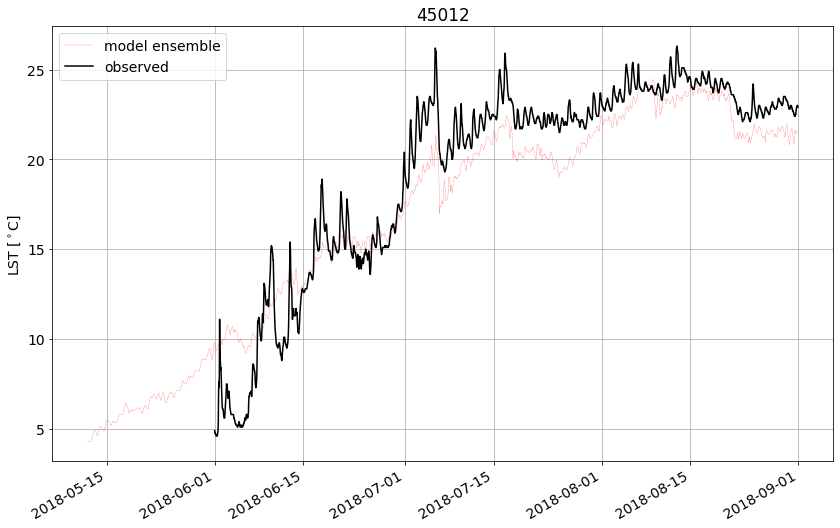

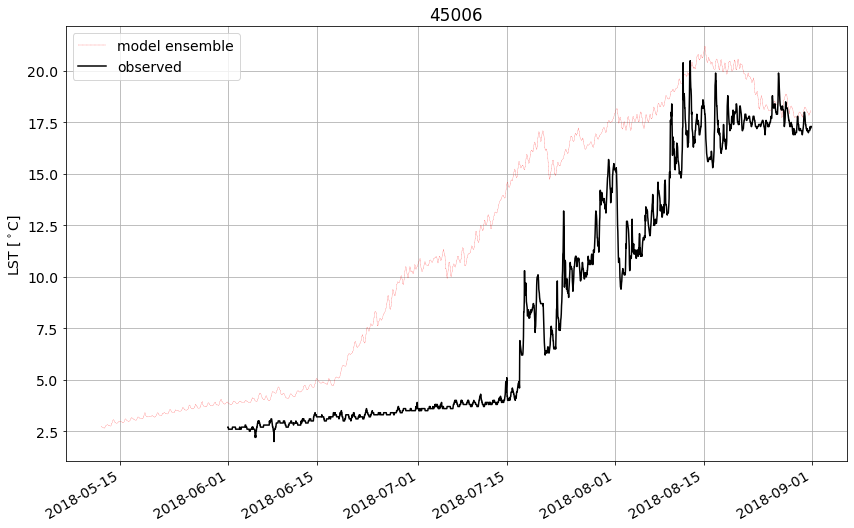

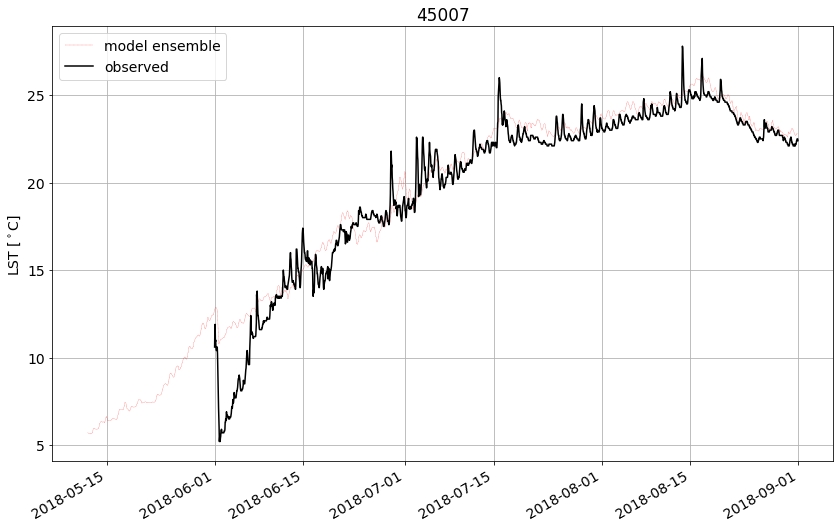

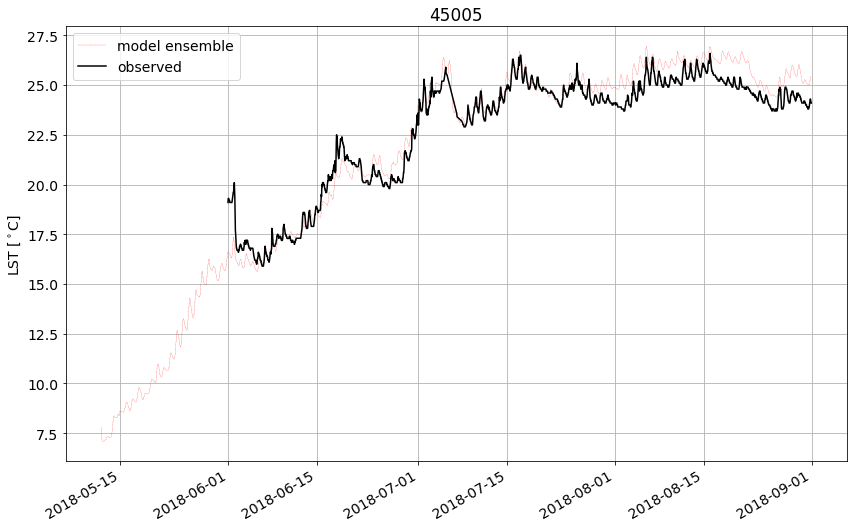

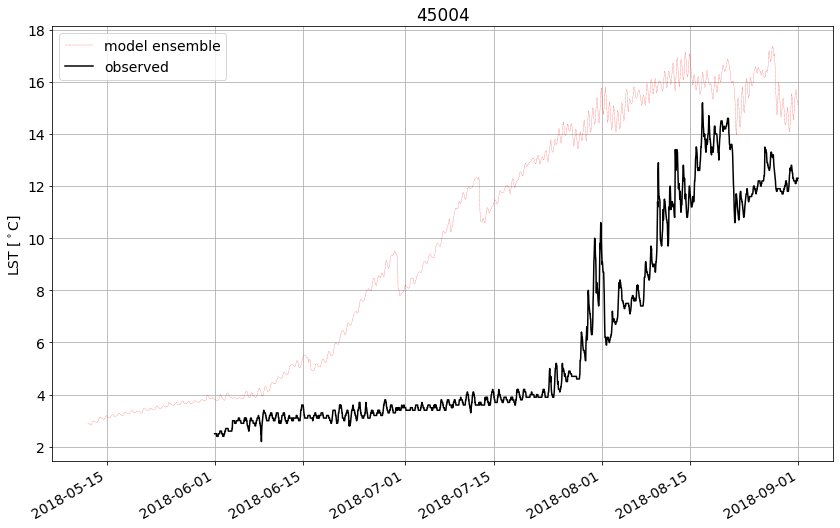

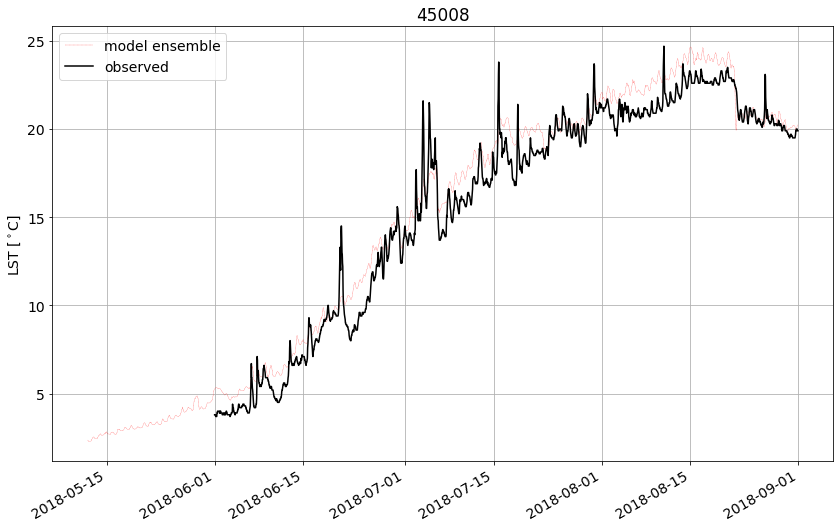

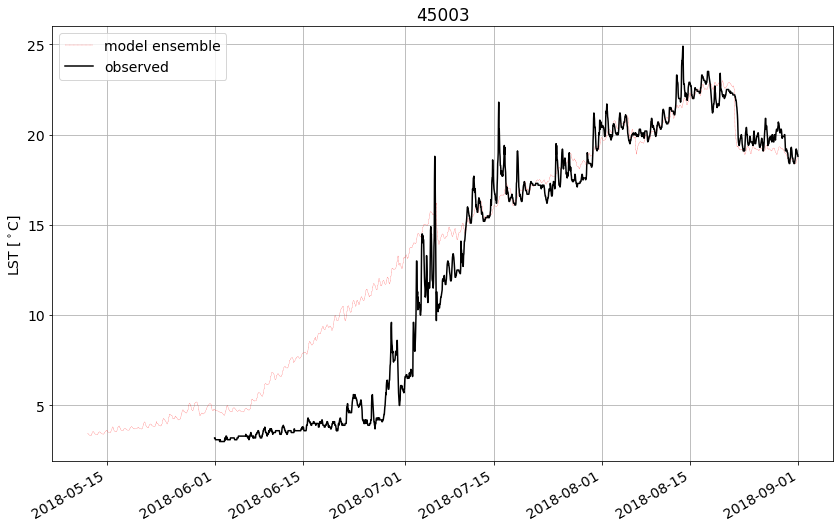

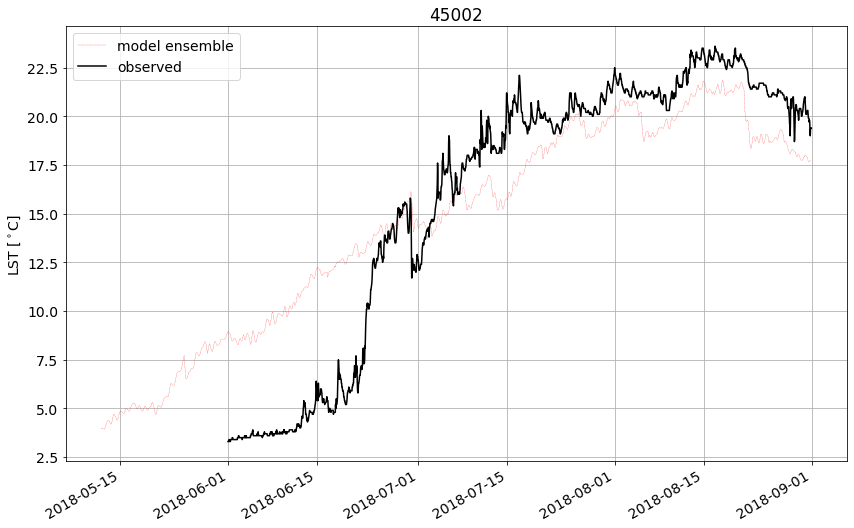

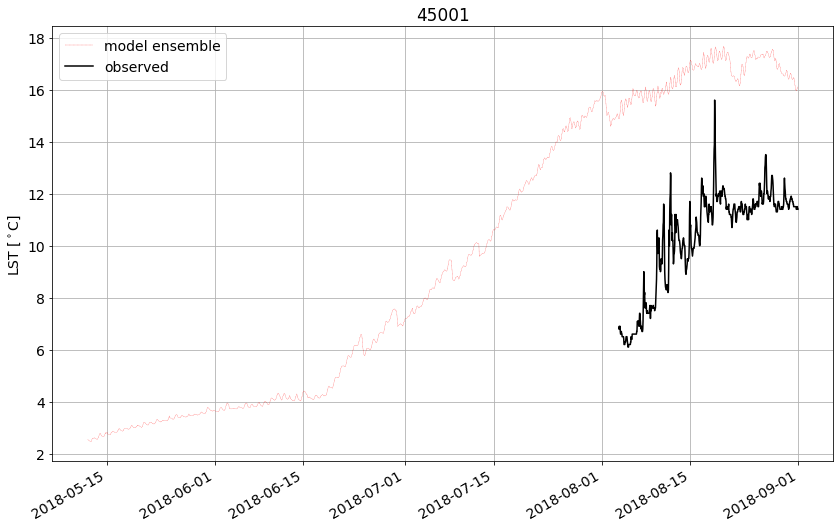

In [12]:
#LST
for bdx, bd in enumerate(buoy_data):
    fig = plt.figure(figsize=(14,8))

    # Download and add the states and coastlines
    buoy_name = buoy_names[bdx]
    
    # plot modeled time series
    for rdx, run in enumerate(wfv_runs['LST']):
        if rdx == 0:
            plt.plot(run[0],run[1][:,bdx],'r--',linewidth=0.25,label='model ensemble')
        else:
            plt.plot(run[0],run[1][:,bdx],'r--',linewidth=0.25)
        
    # plot observed time series
    plt.plot(bd['data']['time'],bd['data']['LST'],'k-',label='observed')

    plt.ylabel('LST [$^\circ$C]')
    plt.xticks(rotation=30, ha='right')
    plt.legend(loc='upper left')
    plt.title(buoy_name)
    plt.grid()
    plt.show()

In [13]:
# removing some bad 2*delta(X) waves
bad_tol = 2 #up and down 2 degree Celcius in between hour forward and back
for rdx, run in enumerate(wfv_runs['T2']):
    bad_pts = 0
    for bdx, bd in enumerate(buoy_data):
        ts = run[1][:,bdx].copy()
        for tdx, tss in enumerate(ts):
            if tdx == 0 or tdx == ts.shape[0]-1:
                continue
            if abs(ts[tdx+1] - tss) > bad_tol and abs(ts[tdx-1] - tss) > bad_tol:
                ts[tdx] = 0.5*(ts[tdx+1] + ts[tdx-1])
                bad_pts += 1
        run[1][:,bdx] = ts
    print(bad_pts)

27


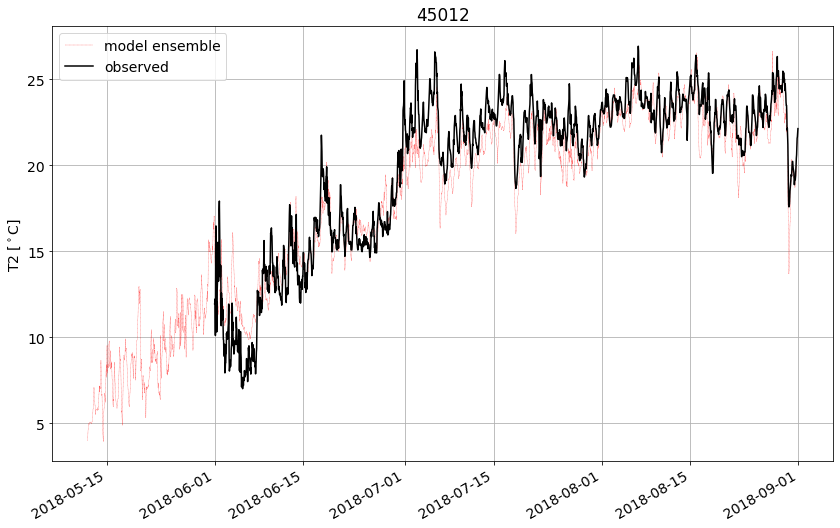

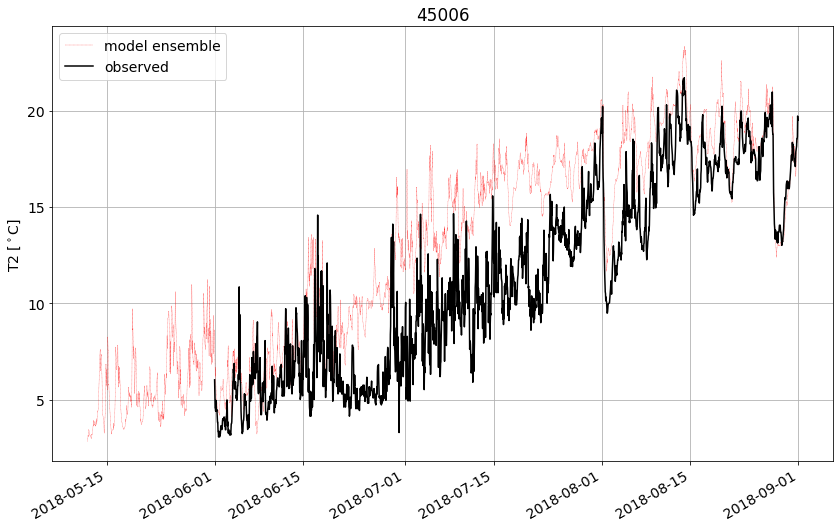

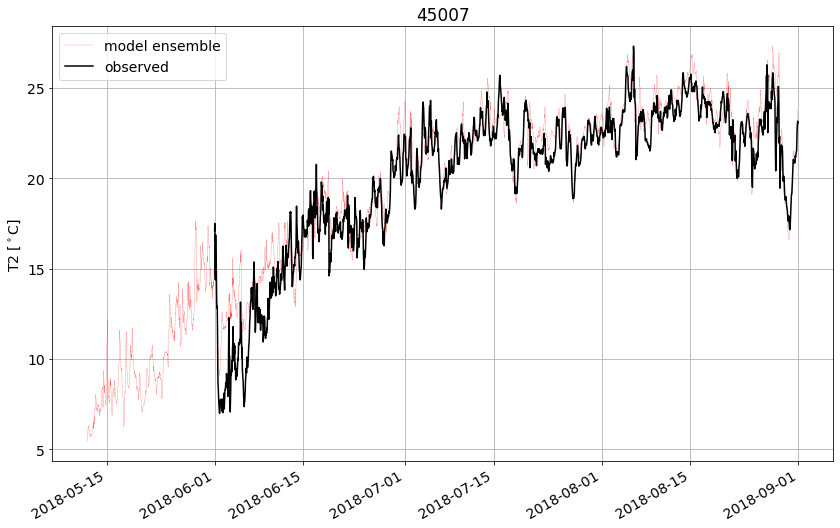

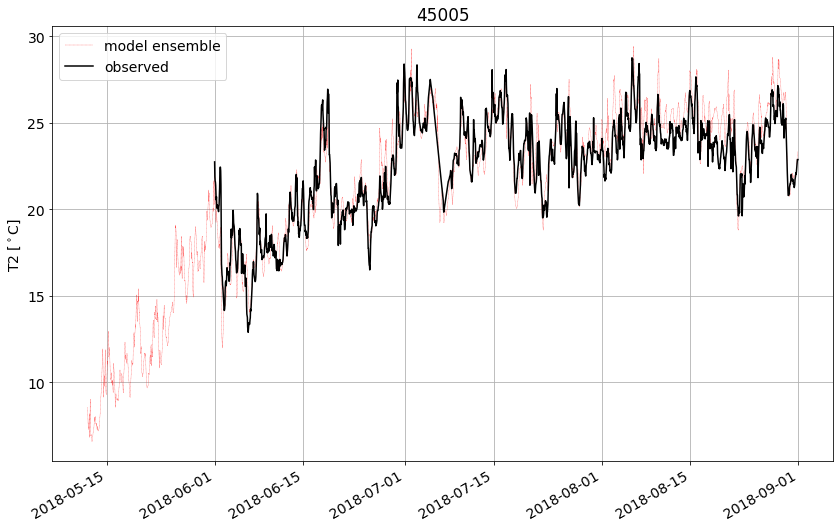

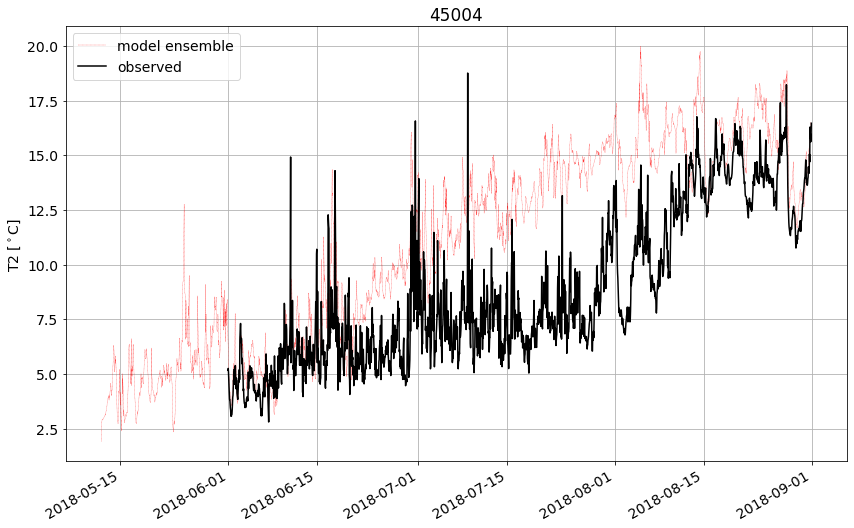

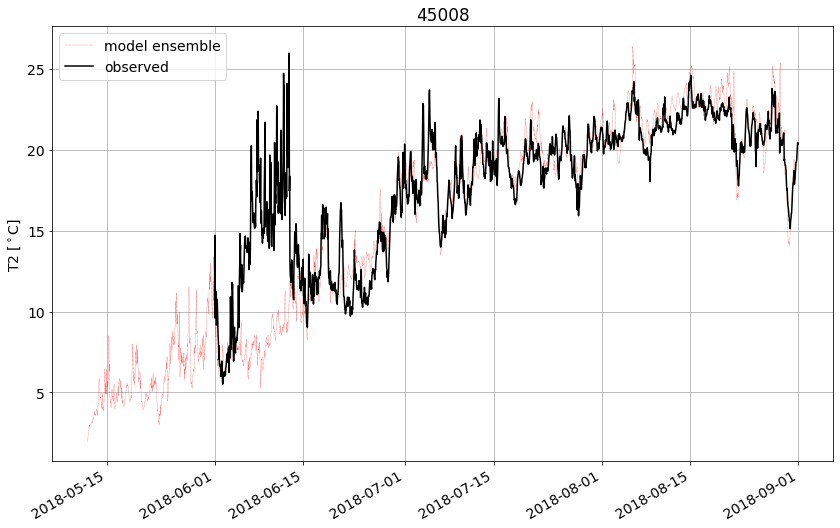

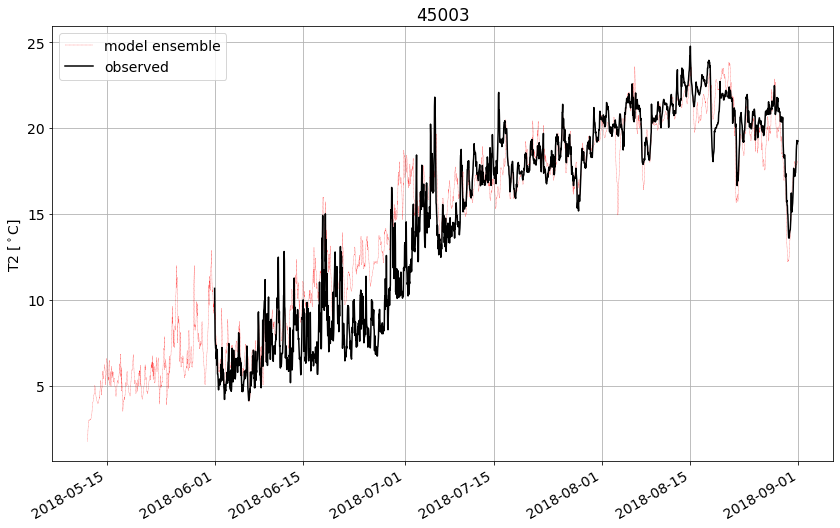

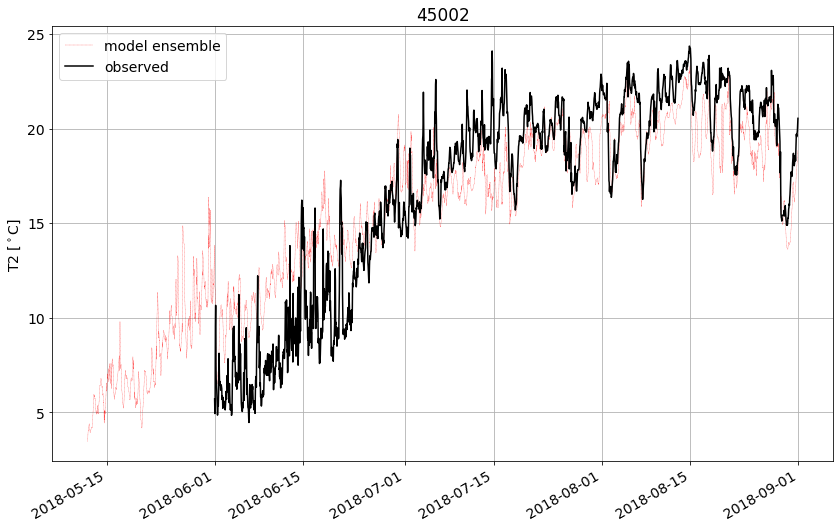

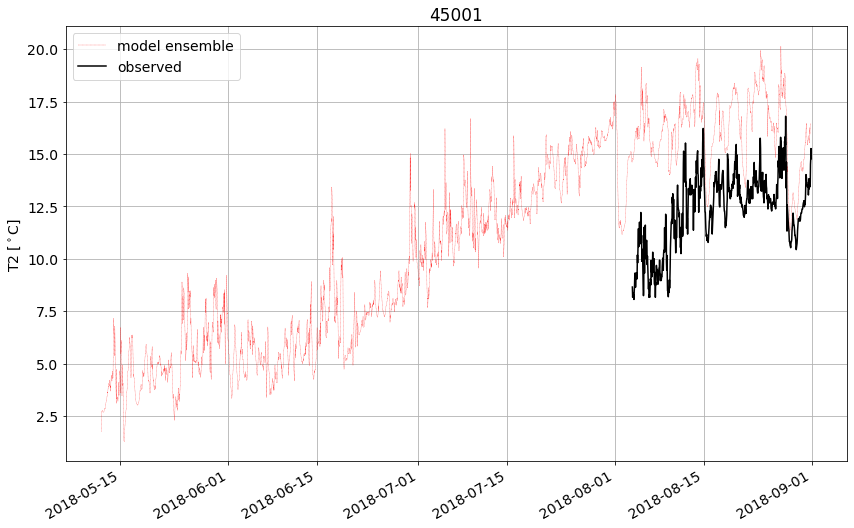

In [14]:
#T2
for bdx, bd in enumerate(buoy_data):
    fig = plt.figure(figsize=(14,8))

    # Download and add the states and coastlines
    buoy_name = buoy_names[bdx]
    
    # plot modeled time series
    for rdx, run in enumerate(wfv_runs['T2']):
        if rdx == 0:
            plt.plot(run[0],run[1][:,bdx],'r--',linewidth=0.25,label='model ensemble')
        else:
            plt.plot(run[0],run[1][:,bdx],'r--',linewidth=0.25)
        #if rdx < 19/2:
        #    plt.plot(run[0],run[1][:,bdx],'x--',linewidth=0.25,label=f'model ensemble {rdx+1}') 
        #else:
        #    plt.plot(run[0],run[1][:,bdx],'^--',linewidth=0.25,label=f'model ensemble {rdx+1}') 
        
    # plot observed time series
    plt.plot(bd['data']['time'],bd['data']['T2'],'k-',label='observed')

    plt.ylabel('T2 [$^\circ$C]')
    plt.xticks(rotation=30, ha='right')
    plt.legend(loc='upper left')
    plt.grid()
    plt.title(buoy_name)
    #plt.xlim([datetime(2018,8,1), datetime(2018,8,3)])
    plt.show()